# Project 4

In this project, you will summarize and present your analysis from Projects 1-3.

### Intro: Write a problem Statement/ Specific Aim for this project

Answer: This project will set out to predict how the reputation and "Prestige" of an undergraduate program effects an application to this graduate program. what are the different probablities for 4 students from each levels of undergrad program with the same scores that they will get into this graduate program? That is the questions that I will set out to answer with this analysis and with the modelt that I am going to build for this project. 

### Dataset:  Write up a description of your data and any cleaning that was completed

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np
plt.style.use('ggplot')
import seaborn as sns
import sklearn.linear_model as lm

In [17]:
df_raw = pd.read_csv("../assets/admissions.csv")
df = df_raw.dropna() 
print df.head()

   admit    gre   gpa  prestige
0      0  380.0  3.61       3.0
1      1  660.0  3.67       3.0
2      1  800.0  4.00       1.0
3      1  640.0  3.19       4.0
4      0  520.0  2.93       4.0


Answer: I took the data from the admissions csv that we have been using throughout the course and I dropped any rows with null values in order to work with a full data set that I can use to make all my calculations. Working without null values also takes out the possibility of errors when making my calculations because I will only be working with records that have a full result set. The current data set lists the identifier for the student, whether they were admitted or not, what their GPA and GRE scores were, and what level of prestige or rank their undergraduate degree is from. 

### Demo: Provide a table that explains the data by admission status

Mean (STD) or counts by admission status for each variable 

| Not Admitted | Admitted
---| ---|---
GPA | mean(std)  | mean(std)
GRE |mean(std) | mean(std)
Prestige 1 | frequency (%) | frequency (%)
Prestige 2 | frequency (%) | frequency (%)
Prestige 3 |frequency (%) | frequency (%)
Prestige 4 |frequency (%) | frequency (%)

In [18]:
dummy_ranks = pd.get_dummies(df['prestige'], prefix='prestige')
print dummy_ranks.head()

   prestige_1.0  prestige_2.0  prestige_3.0  prestige_4.0
0             0             0             1             0
1             0             0             1             0
2             1             0             0             0
3             0             0             0             1
4             0             0             0             1


In [19]:
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_1':])
print data.head()

   admit    gre   gpa  prestige_1.0  prestige_2.0  prestige_3.0  prestige_4.0
0      0  380.0  3.61             0             0             1             0
1      1  660.0  3.67             0             0             1             0
2      1  800.0  4.00             1             0             0             0
3      1  640.0  3.19             0             0             0             1
4      0  520.0  2.93             0             0             0             1


In [20]:
#Gets the mean of each parameter based on whether or not they were admitted 
data.groupby('admit').mean()

,gre,gpa,prestige_1.0,prestige_2.0,prestige_3.0,prestige_4.0
admit,,,,,,
0,573.579336,3.347159,0.103321,0.350554,0.343173,0.202952
1,618.571429,3.489206,0.261905,0.420635,0.222222,0.095238


In [21]:
# frequency table for prestige and whether or not someone was admitted
crosstab2 = pd.crosstab(index=df["admit"], 
                            columns=df["prestige"],
                             margins=True)   # Include row and column totals

crosstab2.columns = ["prestige1","prestige2","prestige3","prestige4","rowtotal"]
crosstab2.index= ["0","1","coltotal"]

crosstab2

,prestige1,prestige2,prestige3,prestige4,rowtotal
0,28,95,93,55,271
1,33,53,28,12,126
coltotal,61,148,121,67,397


In [22]:
crosstab2/crosstab2.ix["coltotal"] 

,prestige1,prestige2,prestige3,prestige4,rowtotal
0,0.459016,0.641892,0.768595,0.820896,0.68262
1,0.540984,0.358108,0.231405,0.179104,0.31738
coltotal,1.000000,1.000000,1.000000,1.000000,1.00000


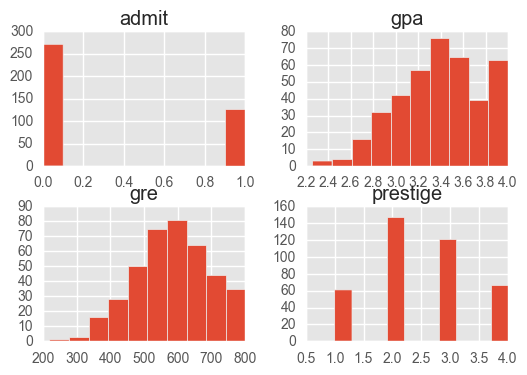

In [23]:
#The histograms for this data set show us the following things 
##More students are rejected than are admitted  
##Their is a high concentration of students in the 3.4-3.6 GPA range with many of the applicants having a 4.0 as well 
##The GRE scores of the applicants are centered in the 600-700 range  
##The majority of the applicants come from schools that were ranked in the second and third tier of undergraduate programs
df.hist()
pl.show()

### Methods: Write up the methods used in your analysis

Answer: I will use a random forrest model in order to determine how the ranking or prestige of their undergraduate school effects their admission and how raising their GPA or GRE score effects their admission to the school depending on the prestige of their undergrad degree. 

In [24]:
#This step creates dummy varialbes so that the prestige of the schools works in 1's and 0's and is not given a numberical value of 1-4. 
#This keeps everything uniform and allows us to judge all of the schools on the same scale.

dummy_ranks = pd.get_dummies(df['prestige'], prefix='prestige')
print dummy_ranks.head()

   prestige_1.0  prestige_2.0  prestige_3.0  prestige_4.0
0             0             0             1             0
1             0             0             1             0
2             1             0             0             0
3             0             0             0             1
4             0             0             0             1


In [25]:
#We then have to join the dummy variables onto our data set so that it can become part of the analysis
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])
print data.head()

   admit    gre   gpa  prestige_2.0  prestige_3.0  prestige_4.0
0      0  380.0  3.61             0             1             0
1      1  660.0  3.67             0             1             0
2      1  800.0  4.00             0             0             0
3      1  640.0  3.19             0             0             1
4      0  520.0  2.93             0             0             1


In [26]:
#We need to set the intercept so that it does not go through the point (0,0)
data['intercept'] = 1.0

In [27]:
#Here is where the data is fit to ensure that we are able to run our model
#There is a fear of overfitting the model but we will check the resuts of fitting our model in the next step
train_cols = data.columns[1:]
logit = sm.Logit(data['admit'], data[train_cols])

# fit the model
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.573854
         Iterations 6


In [28]:
#This step is to show the results of the logistic regression and check that the variables we are using will work
print result.summary()

                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  397
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                            5
Date:                Thu, 16 Mar 2017   Pseudo R-squ.:                 0.08166
Time:                        18:24:27   Log-Likelihood:                -227.82
converged:                       True   LL-Null:                       -248.08
                                        LLR p-value:                 1.176e-07
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
gre              0.0022      0.001      2.028      0.043      7.44e-05     0.004
gpa              0.7793      0.333      2.344      0.019         0.128     1.431
prestige_2.0    -0.6801      0.317     -2.14

In [29]:
#this step generates the data that we will use to run through the model and get our result set
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [30]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
print gres

gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
print gpas



# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]])) 


[ 220.          284.44444444  348.88888889  413.33333333  477.77777778
  542.22222222  606.66666667  671.11111111  735.55555556  800.        ]
[ 2.26        2.45333333  2.64666667  2.84        3.03333333  3.22666667
  3.42        3.61333333  3.80666667  4.        ]


In [31]:
# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1.0, 2.0, 3.0, 4.0], [1.]])) 
combos.columns = ['gre', 'gpa', 'prestige', 'intercept']

In [32]:
# recreate the dummy variables
dummy_ranks = pd.get_dummies(combos['prestige'], prefix='prestige')
dummy_ranks.columns = ['prestige_1.0', 'prestige_2.0', 'prestige_3.0', 'prestige_4.0']

# keep only what we need for making predictions
cols_to_keep = ['gre', 'gpa', 'intercept', 'prestige']
combos = combos[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2.0':])



In [33]:
combos['admit_pred'] = result.predict(combos[train_cols])

print combos.head()

     gre       gpa  intercept  prestige  prestige_2.0  prestige_3.0  \
0  220.0  2.260000        1.0       1.0             0             0   
1  220.0  2.260000        1.0       2.0             1             0   
2  220.0  2.260000        1.0       3.0             0             1   
3  220.0  2.260000        1.0       4.0             0             0   
4  220.0  2.453333        1.0       1.0             0             0   

   prestige_4.0  admit_pred  
0             0    0.164173  
1             0    0.090492  
2             0    0.048977  
3             1    0.039890  
4             0    0.185907  


In [34]:
combos

,gre,gpa,intercept,prestige,prestige_2.0,prestige_3.0,prestige_4.0,admit_pred
0,220.0,2.260000,1.0,1.0,0,0,0,0.164173
1,220.0,2.260000,1.0,2.0,1,0,0,0.090492
2,220.0,2.260000,1.0,3.0,0,1,0,0.048977
3,220.0,2.260000,1.0,4.0,0,0,1,0.039890
4,220.0,2.453333,1.0,1.0,0,0,0,0.185907
5,220.0,2.453333,1.0,2.0,1,0,0,0.103682
6,220.0,2.453333,1.0,3.0,0,1,0,0.056492
7,220.0,2.453333,1.0,4.0,0,0,1,0.046078
8,220.0,2.646667,1.0,1.0,0,0,0,0.209795
9,220.0,2.646667,1.0,2.0,1,0,0,0.118543


### Results: Write up your results

Answer: 
This result set will give us the proababilty of admission for all GRE scores, GPA scores, and what level of prestige the applicants undergraduate degree is from. Any lines with 0 values for all of the prestige columns means that the applicant went to an undergrad program with a prestige value of 1. 

Given a perfect score on your GPA and GRE there is a 73% chance of getting in if you went to the highest ranked schools, a 58% chance of getting in if you went to the second highest rated schools, a 42% chance if you went to the third highest rated schools, and a 37% chance if you went to the worst ranked schools. The difference between all of the percentages represents how they weigh the school you went to with everything else being held constant. The reason why there is not 100% admission for the top ranked schools is because the entire application is not based purely on quantitative results and there are still essays to be written and recommendations that need to be sent in order to finish your application. Someone who has perfect scores from the best school could still be denied admission because they write a bad essay or have no relevant experience in the field of study they are trying to pursue.  



### Visuals: Provide a table or visualization of these results

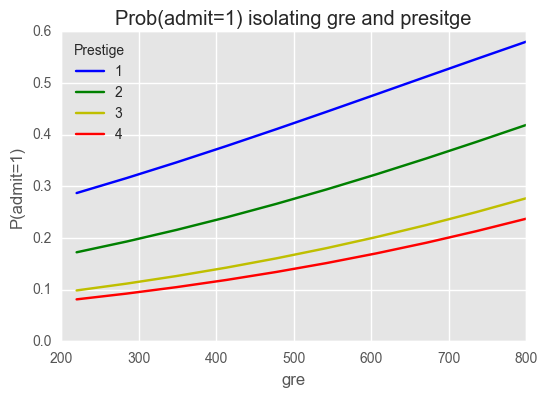

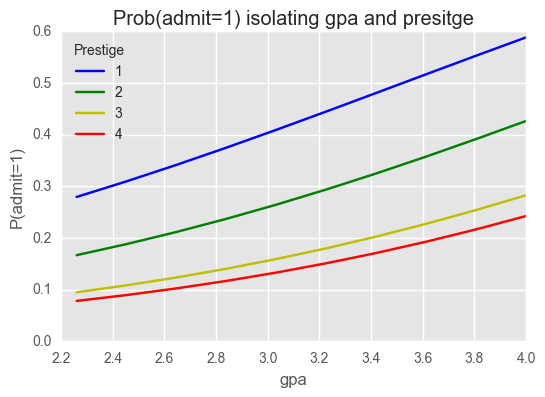

In [37]:
def isolate_and_plot(variable):
    # isolate gre and class rank
    grouped = pd.pivot_table(combos, values=['admit_pred'], index=[variable, 'prestige'],
                            aggfunc=np.mean)
    
    
    # make a plot
    colors = 'rbgyrbgy'
    for col in combos.prestige.unique():
        plt_data = grouped.ix[grouped.index.get_level_values(1)==col]
        pl.plot(plt_data.index.get_level_values(0), plt_data['admit_pred'],
                color=colors[int(col)])

    pl.xlabel(variable)
    pl.ylabel("P(admit=1)")
    pl.legend(['1', '2', '3', '4'], loc='upper left', title='Prestige')
    pl.title("Prob(admit=1) isolating " + variable + " and presitge")
    pl.show()

isolate_and_plot('gre')
isolate_and_plot('gpa')

In [ ]:
#These graphs show the probability that a student will get into the graduate program depending on their GRE/GRE Scores 

### Discussion: Write up your discussion and future steps

Answer: We see that there is a correlation between having higher scores and admission as well as going to a better school and admission. the next steps I would take to make this analysis even richer would be to quantify the rest of the students application. I would attempt to assign a score to each applicants essays, recommendations, and other application pieces. This would allow me to see how these parameters of the application process effect the admission status of the applicant. If a student with perfect scores from the best school writes a terrible essay will they still get in? If there is an interview process and the applicant is terrible at interviewing and lacks social skills how does that effect their admission? 